In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "playground-series-s4e1"

# 1 Exploratory data analysis

**1.1 Load libraries**

In [2]:

library(ggplot2)
library(dplyr)
library(gridExtra)
library(patchwork)
library(data.table)
library(lightgbm)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice




**1.2 Read the train and test data**

In [3]:

set.seed(42)

train_data <- fread("/kaggle/input/playground-series-s4e1/train.csv")
test_data <- fread("/kaggle/input/playground-series-s4e1/test.csv")

**1.3 Display basic information about the dataset**

In [4]:
head(train_data)


id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
<int>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
0,15674932,Okwudilichukwu,668,France,Male,33,3,0.0,2,1,0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33,1,0.0,2,1,1,49503.50,0
2,15694510,Hsueh,678,France,Male,40,10,0.0,2,1,0,184866.69,0
3,15741417,Kao,581,France,Male,34,2,148882.5,1,1,1,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33,5,0.0,2,1,1,15068.83,0
5,15771669,Genovese,588,Germany,Male,36,4,131778.6,1,1,0,136024.31,1


**1.5 Check for missing values**

In [5]:
print(colSums(is.na(train_data)))


             id      CustomerId         Surname     CreditScore       Geography 
              0               0               0               0               0 
         Gender             Age          Tenure         Balance   NumOfProducts 
              0               0               0               0               0 
      HasCrCard  IsActiveMember EstimatedSalary          Exited 
              0               0               0               0 


In [6]:
print(colSums(is.na(test_data)))

             id      CustomerId         Surname     CreditScore       Geography 
              0               0               0               0               0 
         Gender             Age          Tenure         Balance   NumOfProducts 
              0               0               0               0               0 
      HasCrCard  IsActiveMember EstimatedSalary 
              0               0               0 


# Data Viz

**2.1 Plot distribution of 'Exited' variable with labels***

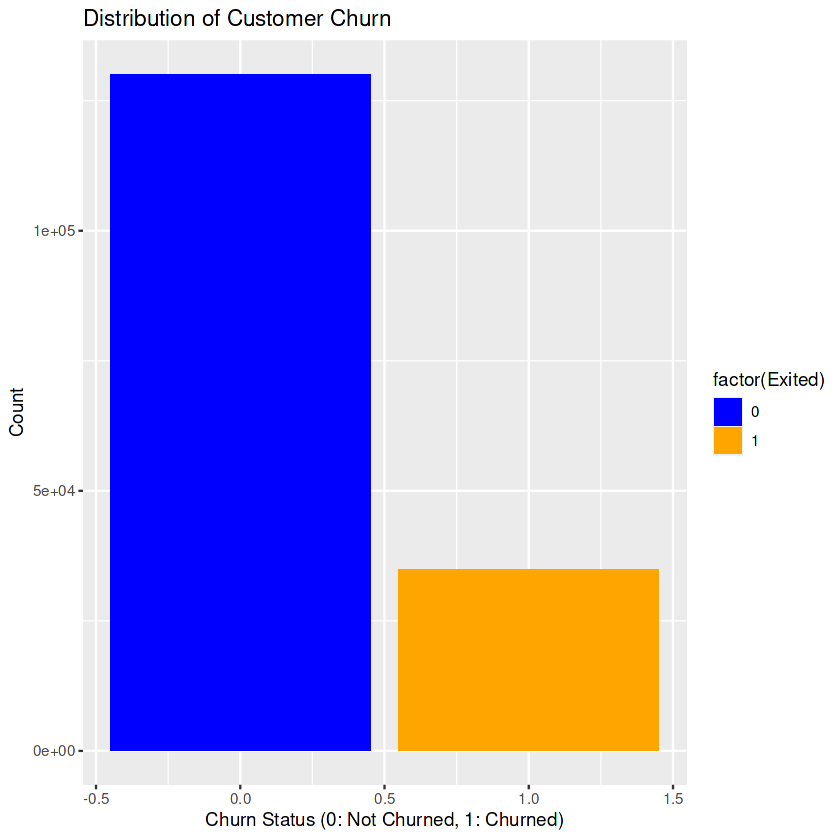

In [7]:
ggplot(train_data, aes(x = Exited, fill = factor(Exited))) +
        geom_bar() +
        ggtitle('Distribution of Customer Churn') +
        xlab('Churn Status (0: Not Churned, 1: Churned)') +
        ylab('Count') +
        scale_fill_manual(values = c('0' = 'blue', '1' = 'orange'))


**2.2 Plot count distribution for categorical variables**

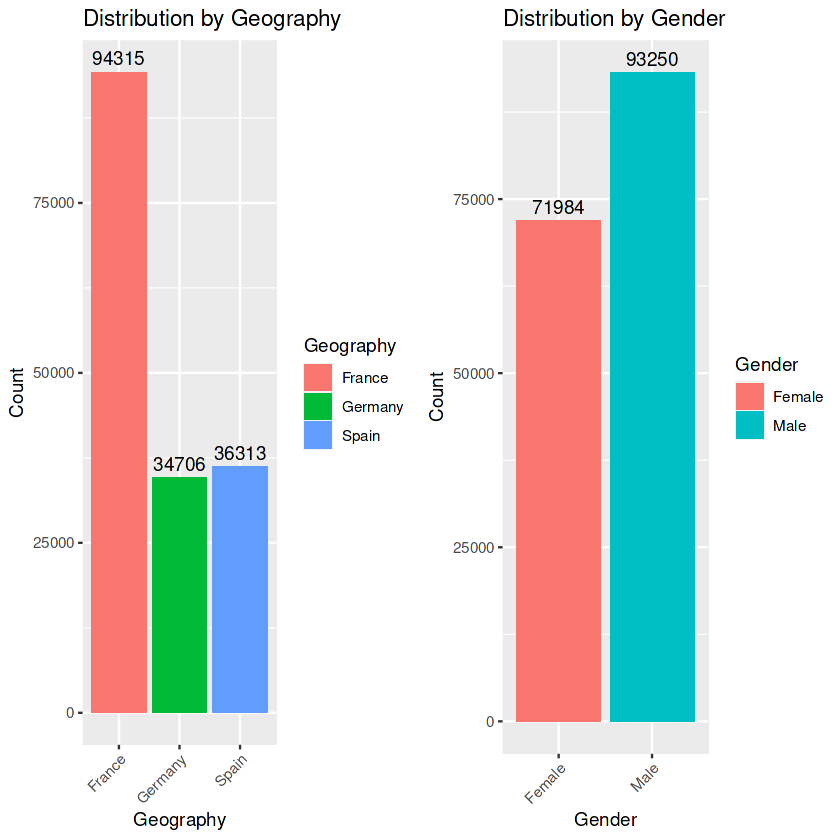

In [8]:
 
plt1 <- ggplot(train_data, aes(x = Geography, fill = Geography)) +
        geom_bar() +
        ggtitle('Distribution by Geography') +
        xlab('Geography') +
        ylab('Count') +
        geom_text(stat = 'count', aes(label = after_stat(count + 100)), vjust = -0.5) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

plt2 <- ggplot(train_data, aes(x = Gender, fill = Gender)) +
        geom_bar() +
        ggtitle('Distribution by Gender') +
        xlab('Gender') +
        ylab('Count') +
        geom_text(stat = 'count', aes(label = after_stat(count + 100)), vjust = -0.5) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))

gridExtra::grid.arrange(plt1, plt2, ncol = 2)

**2.3 counts and proportions for Geography and Gender**

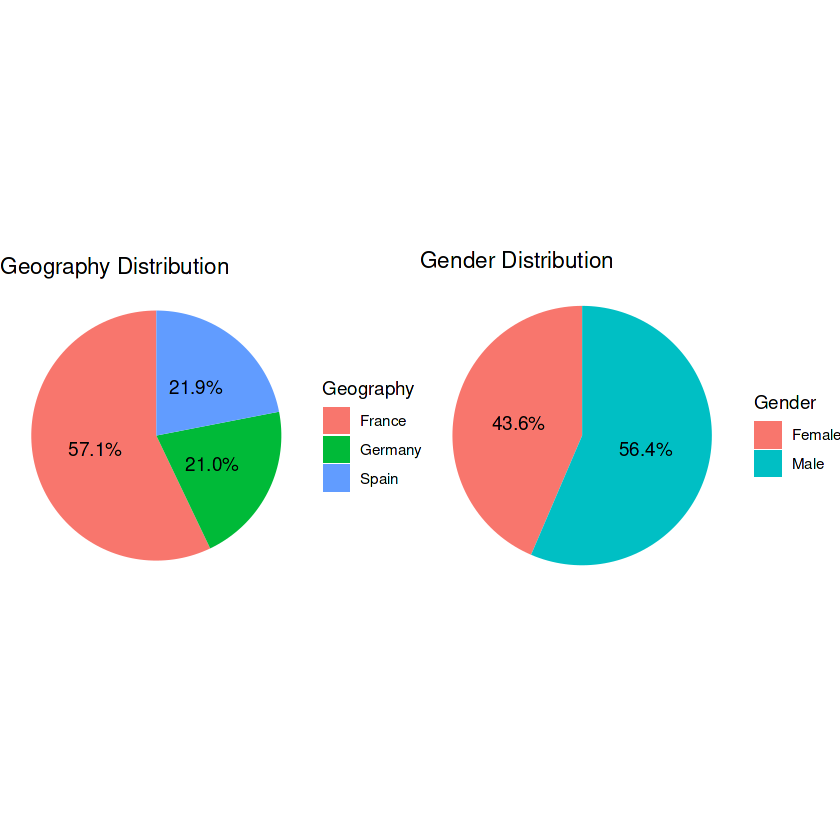

In [9]:
geo_counts <- train_data %>% 
        group_by(Geography) %>% 
        summarise(count = n()) %>% 
        mutate(prop = count / sum(count) * 100)

plt3 <- ggplot(geo_counts, aes(x = "", y = prop, fill = Geography)) +
        geom_bar(width = 1, stat = "identity") +
        coord_polar(theta = 'y') +
        ggtitle('Geography Distribution') +
        theme_void() +
        geom_text(aes(label = sprintf("%1.1f%%", prop)),
                  position = position_stack(vjust = 0.5))

gender_counts <- train_data %>% 
        group_by(Gender) %>% 
        summarise(count = n()) %>% 
        mutate(prop = count / sum(count) * 100)

plt4 <- ggplot(gender_counts, aes(x = "", y = prop, fill = Gender)) +
        geom_bar(width = 1, stat = "identity") +
        coord_polar(theta = 'y') +
        ggtitle('Gender Distribution') +
        theme_void() +
        geom_text(aes(label = sprintf("%1.1f%%", prop)),
                  position = position_stack(vjust = 0.5))

gridExtra::grid.arrange(plt3, plt4, ncol = 2)


# 3 Feature Engineering

**3.1 Sample feature engineering for age groups**

In [10]:

train_data$Age_Group <- cut(train_data$Age, breaks = c(18, 25, 35, 50, 70, 100), labels = c("18-25", "26-35", "36-50", "51-70", "71+"))
test_data$Age_Group <- cut(test_data$Age, breaks = c(18, 25, 35, 50, 70, 100), labels = c("18-25", "26-35", "36-50", "51-70", "71+"))

**3.2 Encoding categorical variables**

In [11]:
train_data[, Geography := as.factor(Geography)]
train_data[, Gender := as.factor(Gender)]
train_data[, Age_Group := as.factor(Age_Group)]

test_data[, Geography := as.factor(Geography)]
test_data[, Gender := as.factor(Gender)]
test_data[, Age_Group := as.factor(Age_Group)]

# 4 Model Training

**4.1 Prepare data for LightGBM**

In [12]:
train_data_lgb <- lgb.Dataset(data = as.matrix(train_data[, -c("id", "CustomerId", "Surname", "Exited")]), 
                               label = as.numeric(train_data$Exited) - 1,
                               categorical_feature = c("Geography", "Gender", "Age_Group"))

Warning message in storage.mode(data) <- "double":
“NAs introduced by coercion”


**4.2 Set LightGBM parameters**

In [13]:
lgb_params <- list(objective = "binary",
                   metric = "auc",
                   boosting_type = "gbdt",
                   num_leaves = 31,
                   learning_rate = 0.05,
                   feature_fraction = 0.9,
                   bagging_fraction = 0.8,
                   bagging_freq = 5,
                   verbose = -1)

**4.3 train Lightgbm**

In [14]:
lgb_model <- lgb.train(params = lgb_params, data = train_data_lgb, nrounds = 1000, early_stopping_rounds = 100, valids = list(val = train_data_lgb))

[1]:	val's auc:1 
[2]:	val's auc:1 
[3]:	val's auc:1 
[4]:	val's auc:1 
[5]:	val's auc:1 
[6]:	val's auc:1 
[7]:	val's auc:1 
[8]:	val's auc:1 
[9]:	val's auc:1 
[10]:	val's auc:1 
[11]:	val's auc:1 
[12]:	val's auc:1 
[13]:	val's auc:1 
[14]:	val's auc:1 
[15]:	val's auc:1 
[16]:	val's auc:1 
[17]:	val's auc:1 
[18]:	val's auc:1 
[19]:	val's auc:1 
[20]:	val's auc:1 
[21]:	val's auc:1 
[22]:	val's auc:1 
[23]:	val's auc:1 
[24]:	val's auc:1 
[25]:	val's auc:1 
[26]:	val's auc:1 
[27]:	val's auc:1 
[28]:	val's auc:1 
[29]:	val's auc:1 
[30]:	val's auc:1 
[31]:	val's auc:1 
[32]:	val's auc:1 
[33]:	val's auc:1 
[34]:	val's auc:1 
[35]:	val's auc:1 
[36]:	val's auc:1 
[37]:	val's auc:1 
[38]:	val's auc:1 
[39]:	val's auc:1 
[40]:	val's auc:1 
[41]:	val's auc:1 
[42]:	val's auc:1 
[43]:	val's auc:1 
[44]:	val's auc:1 
[45]:	val's auc:1 
[46]:	val's auc:1 
[47]:	val's auc:1 
[48]:	val's auc:1 
[49]:	val's auc:1 
[50]:	val's auc:1 
[51]:	val's auc:1 
[52]:	val's auc:1 
[53]:	val's auc:1 
[5

**4.4 predictions on the test data**

In [15]:
test_predictions <- predict(lgb_model, as.matrix(test_data[, -c("id", "CustomerId", "Surname")]))

# Create submission file

In [16]:

submission <- data.table(id = test_data$id, Exited = test_predictions)
fwrite(submission, "submission.csv", quote = FALSE)
